In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy.special import gammaln as gammaln
from scipy.optimize import minimize as minimize
from scipy.special import digamma as digamma

[ 4  7  5  7  4  5 10  6  5  5 10  4  5  6  8  5  6 26 10 26 26 25 27 27 29
 31 22 19 21 14 26  9 12 18 15 14 13 12 14 17 18 21 15 23 13 19 10 15 19 18
 23 20 21 23 21 20  8  3  7  7  4  9  1  3  3  3  2  5  9  5  2  4  3  4  5
  9  6  4  5  6  3  1  1  7  2  2 32  9  5 10  5  0  2  2  1  1  2  0 20 15]


<Container object of 100 artists>

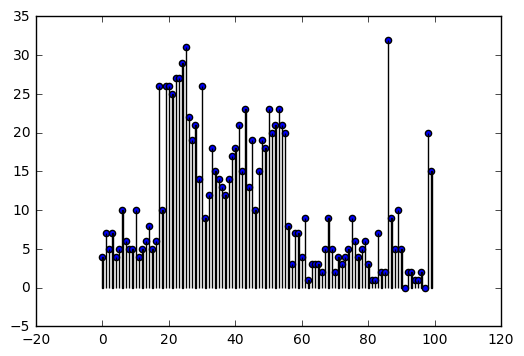

In [29]:
M=100
nu=0.9
B=0.05
a0=5
b0=0.2
log_p1 = np.log(0.1)
log_p0 = np.log(1-np.exp(log_p1))

r = np.random.rand(M)<np.exp(log_p1)
r= np.array(r,dtype=int)

lambda0 = np.random.gamma(a0,1/b0)
lambdaG = np.zeros((1,M))

for t in range(M):
    if r[t] == 1:
        lambdaG[0,t] = np.random.gamma(nu,1/B)
    else:
        if t > 0:
            lambdaG[0,t]=lambdaG[0,t-1]
        else:
            lambdaG[0,t]=lambda0
            
x = np.random.poisson(lambdaG[0,:])
print x
plt.scatter(range(len(x)),x)
plt.bar(range(len(x)),x,width=0.1)

In [101]:
#SUPLEMENTARY FUNCTIONS
def Update(g,x):
    M = g.shape[0]
    gu = np.zeros(g.shape)
    for i in range(M):
        a = g[i,0]
        b= g[i,1]
        c= g[i,2]
        q= gammaln(a+x)-gammaln(a)-gammaln(x+1)+np.log(b+1)+a*np.log(b/(b+1))+(x+1)*np.log(1/(b+1))
        gu[i,0]=a+x
        gu[i,1]=b+1
        gu[i,2]=c+q
    return gu

def moGamma(g,lambd):
    J = g.shape[0]
    lg=np.zeros(lambd.shape)
    Z = misc.logsumexp(g[:,2],0)
    for q in range(lg.shape[0]):
        a = g[:,0]
        b = g[:,1]
        lg[q] =sum(np.exp(g[:,2]-Z+(a-1)*np.log(lambd[q])-b*lambd[q]-gammaln(a)+a*np.log(b)))
    return lg

def gamPot(g1,g2):
    g2 = g2[0][0]
    m1 = g1.shape[0]
    m2 = g2.shape[0]
    gp = np.zeros((m1,1,3))
    
    for i in range(m1):
        a= g1[i,0] + g2[0] - 1
        b= g1[i,1] + g2[1]
        g=gammaln(a) - gammaln(g1[i,0]) - gammaln(g2[0]) + np.log(b) + g1[i,0]*np.log(g1[i,1]/b) + g2[0]*np.log(g2[1]/b)
        c= g1[i,2] + g2[2] + g
        gp[i,0,:]=[a,b,c]
    return gp

#function for finding inverse of digamma
def fts(x):
    global var
    return np.abs(var - digamma(x))

def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] + delta/2]

In [98]:
#Forward
def Forward(nu,B,log_p1,a0,b0,log_p0):
    ff=np.zeros((M+1,M,3))
    fp=np.zeros((M+1,M,3))
    for t in range(M):
        if t == 0:
            tau = 0
            fp[tau,t,:]=np.reshape([nu,B,log_p1],[1,1,3])
            tau = 1
            fp[tau,t,:]=np.reshape([a0,b0,log_p0],[1,1,3])
        else:
            c = misc.logsumexp(ff[0:(t+1),t-1,2])
            tau = 0
            fp[0,t,:] = np.reshape([nu,B,log_p1+c],[1,1,3])
            tau=range(1,t+1)
            fp[1:(t+2),t,:] = ff[0:(t+1),t-1,:]
            for q in range(1,t+2):
                fp[q,t,2] = fp[q,t,2]+log_p0 
        ff[0:(t+2),t,:] = Update(fp[0:(t+2),t,:],x[t])
    return ff,fp

In [99]:
# Backward pass (Ard arda 0 gelen datalarda bazen log fonksiyonundan kaynaklanan hata oluyor)
def Backward(nu,B,log_p1,log_p0):
    bf=np.zeros((M+1,M,3))
    for t in range(M)[::-1]:
        if t==(M-1):
            tau=0
            bf[tau , t, :] = np.reshape([x[t]+1,1,0],[1,1,3])
        else:
            tau=0
            temp=gamPot(bf[0:(M-(t+1)),t+1,:],np.reshape([nu,B,0],[1,1,3]))
            c= misc.logsumexp(temp[:,0,2])
            bf[tau,t,:] = np.reshape([x[t],1,log_p1+c],[1,1,3])
            bf[1:(M-t),t,:]=gamPot(bf[0:(M-t-1),t+1,:],np.reshape([x[t]+1,1,log_p0],[1,1,3]))[:,0]
    return bf

In [102]:
def FinalizeResults(fp,bf):
    lam=np.linspace(0.01,max(x),M)
    pr = np.zeros((2,M))    
    prs = np.zeros((2,M))
    LAM = np.zeros((len(lam),M))
    LAMS = np.zeros((len(lam),M))

    for k in range(M):
        pr[0,k] =  ff[0,k,2]
        pr[1,k] =  misc.logsumexp(ff[1:(k+2),k,2])
        LAM[:,k] = moGamma(ff[0:(k+2),k,:],lam)

    for j in range(M)[::-1]:
        gamma = np.zeros((fp[0:(j+2),j,:].shape[0],bf[0:(M-j),j,:].shape[0],3))
        for k in range(bf[0:(M-j),j,:].shape[0]):
            gamma[:,k,:] = gamPot(fp[0:(j+2),j,:],np.reshape(bf[k,j,:],[1,1,3]))[:,0]
        prs[0,j]=misc.logsumexp(gamma[0,:,2])
        c = gamma[1:(gamma.shape[0]),:,2]
        prs[1,j]=misc.logsumexp(misc.logsumexp(c))
        LAMS[:,j]=moGamma(np.reshape(gamma,[gamma.shape[0]*gamma.shape[1],1,3])[:,0],lam)
    return lam,prs,LAMS,pr,LAM

In [51]:
M=100
nu=0.9
B=0.05
a0=5
b0=0.2
log_p1 = np.log(0.1)
log_p0 = np.log(1-np.exp(log_p1))

ff,fp = Forward(nu,B,log_p1,a0,b0,log_p0)
bf = Backward(nu,B,log_p1,log_p0)

def FinalizeResults(fp,bf):
    lam=np.linspace(0.01,max(x),100)
    pr = np.zeros((2,M))    
    prs = np.zeros((2,M))
    LAM = np.zeros((len(lam),M))
    LAMS = np.zeros((len(lam),M))

    for k in range(M):
        pr[0,k] =  ff[0,k,2]
        pr[1,k] =  misc.logsumexp(ff[1:(k+2),k,2])
        LAM[:,k] = moGamma(ff[0:(k+2),k,:],lam)

    for j in range(M)[::-1]:
        gamma = np.zeros((fp[0:(j+2),j,:].shape[0],bf[0:(M-j),j,:].shape[0],3))
        for k in range(bf[0:(M-j),j,:].shape[0]):
            gamma[:,k,:] = gamPot(fp[0:(j+2),j,:],np.reshape(bf[k,j,:],[1,1,3]))[:,0]
        prs[0,j]=misc.logsumexp(gamma[0,:,2])
        c = gamma[1:(gamma.shape[0]),:,2]
        prs[1,j]=misc.logsumexp(misc.logsumexp(c))
        LAMS[:,j]=moGamma(np.reshape(gamma,[gamma.shape[0]*gamma.shape[1],1,3])[:,0],lam)
    return lam,prs,LAMS,pr,LAM
lam,prs,LAMS,pr,LAM = FinalizeResults(fp,bf)

In [105]:
var = 0
def EM(a0,b0,a_new,b_new,r_new,epsilon):
    while True:
        a = a_new
        b = b_new
        r = r_new
        log_p1 = np.log(r)
        log_p0 = np.log(1-np.exp(log_p1))
        ff,fp = Forward(a,b,log_p1,a0,b0,log_p0)
        bf = Backward(a,b,log_p1,log_p0)
        lam=np.linspace(0.01,max(x),len(x))
        LAMS = np.zeros((len(lam),M))
        prs = np.zeros((2,M))
        for j in range(M)[::-1]:
            gamma = np.zeros((fp[0:(j+2),j,:].shape[0],bf[0:(M-j),j,:].shape[0],3))
            for k in range(bf[0:(M-j),j,:].shape[0]):
                gamma[:,k,:] = gamPot(fp[0:(j+2),j,:],np.reshape(bf[k,j,:],[1,1,3]))[:,0]
            prs[0,j]=misc.logsumexp(gamma[0,:,2])
            c = gamma[1:(gamma.shape[0]),:,2]
            prs[1,j]=misc.logsumexp(misc.logsumexp(c))
            LAMS[:,j]=moGamma(np.reshape(gamma,[gamma.shape[0]*gamma.shape[1],1,3])[:,0],lam)
        tempP1 = np.exp(prs[1,:])/(np.exp(prs[0,:])+np.exp(prs[1,:]))
        tempP0 = np.exp(prs[0,:])/(np.exp(prs[0,:])+np.exp(prs[1,:]))
        prs[1,:]=tempP1
        prs[0,:]=tempP0
        sumPosteriorS = sum(prs[0,:])
        
        temp1 = sumPosteriorS*np.log(b)
        temp2 = 0
        for t in range(M):
            normalized = LAMS[:,t]/sum(LAMS[:,t])
            temp2 = temp2 + prs[0,t]*np.sum(np.multiply(np.log(lam),normalized))
        global var
        var = (temp1+temp2)/(sumPosteriorS)
        a_new = minimize(fts,0.05,bounds =[(0,None)] ).x[0]
        
        temp3=0
        for t in range(M):
            normalized = LAMS[:,t]/sum(LAMS[:,t])
            temp3 = temp3 + prs[0,t]*np.sum(np.multiply(lam,normalized))
        b_new = sumPosteriorS*a_new/(temp3)
        r_new = np.mean(prs[0,:])
        if np.abs(b-b_new) < epsilon and np.abs(a-a_new) < epsilon and np.abs(r-r_new) < epsilon:
            break
        print a_new,b_new,r_new
    return r,a,b

In [107]:
r,a,b = EM(a0=5,b0=0.2,a_new = 9,b_new = 2.89,r_new = 0.044,epsilon = 0.00001)

8.64258904077 2.87307090289 0.0420548597493
8.46279009922 2.85657961971 0.0415586109016
8.35730438851 2.84085552769 0.0415384621213
8.28385653907 2.82596390392 0.0416681795308
8.22543484115 2.81189120315 0.0418332380122
8.17510546633 2.79860071961 0.04199415285
8.1299261392 2.78605017935 0.0421388528373
8.08854711726 2.77419742272 0.0422651764834
8.05026842436 2.76300218917 0.0423743260538
8.01466750281 2.75242657462 0.0424684374618
7.98145005037 2.74243504569 0.0425497104196
7.95038851008 2.73299432312 0.0426201268515
7.92129526679 2.72407322014 0.0426813862219
7.89400989488 2.715642482 0.0427349164889
7.86839233143 2.70767464408 0.0427819076696
7.84431866142 2.70014388986 0.0428233487692
7.82167826242 2.69302593696 0.0428600616365
7.80037166407 2.68629792599 0.0428927300541
7.78030888523 2.67993832235 0.0429219240699
7.76140809686 2.67392682562 0.0429481201016
7.74359454004 2.66824429003 0.04297171746
7.7267996341 2.66287265166 0.0429930518938
7.71096022685 2.65779485849 0.0430124066

KeyboardInterrupt: 

In [ ]:
M=len(x)
nu=a
B=b
a0=5
b0=0.2
log_p1 = np.log(r)
log_p0 = np.log(1-np.exp(log_p1))

ff,fp = Forward(nu,B,log_p1,a0,b0,log_p0)
bf = Backward(nu,B,log_p1,log_p0)

def FinalizeResults(fp,bf):
    lam=np.linspace(0.01,max(x),100)
    pr = np.zeros((2,M))    
    prs = np.zeros((2,M))
    LAM = np.zeros((len(lam),M))
    LAMS = np.zeros((len(lam),M))

    for k in range(M):
        pr[0,k] =  ff[0,k,2]
        pr[1,k] =  misc.logsumexp(ff[1:(k+2),k,2])
        LAM[:,k] = moGamma(ff[0:(k+2),k,:],lam)

    for j in range(M)[::-1]:
        gamma = np.zeros((fp[0:(j+2),j,:].shape[0],bf[0:(M-j),j,:].shape[0],3))
        for k in range(bf[0:(M-j),j,:].shape[0]):
            gamma[:,k,:] = gamPot(fp[0:(j+2),j,:],np.reshape(bf[k,j,:],[1,1,3]))[:,0]
        prs[0,j]=misc.logsumexp(gamma[0,:,2])
        c = gamma[1:(gamma.shape[0]),:,2]
        prs[1,j]=misc.logsumexp(misc.logsumexp(c))
        LAMS[:,j]=moGamma(np.reshape(gamma,[gamma.shape[0]*gamma.shape[1],1,3])[:,0],lam)
    return lam,prs,LAMS,pr,LAM
lam,prs,LAMS,pr,LAM = FinalizeResults(fp,bf)

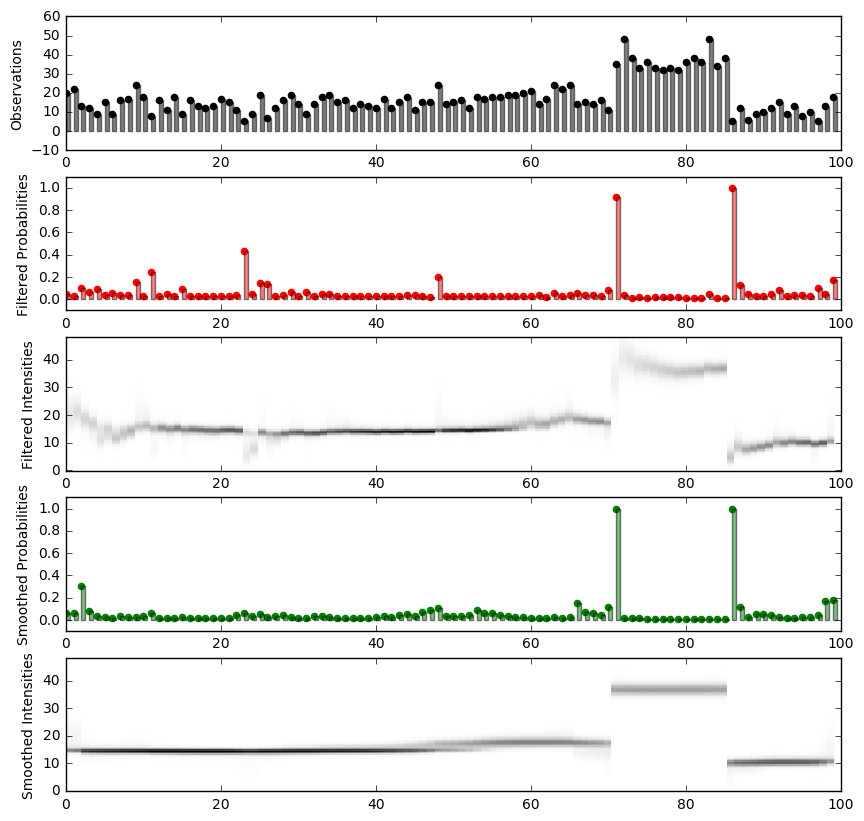

In [52]:
fig, axes = plt.subplots(nrows=5,figsize=(10,10))
data=np.zeros((5,100))
data[0,:]=x
data[1,:]=np.exp(pr[0,:])/(np.exp(pr[0,:])+np.exp(pr[1,:]))
data[3,:]=np.exp(prs[0,:])/(np.exp(prs[0,:])+np.exp(prs[1,:]))
labels = ('Observations','Filtered Probabilities','Filtered Intensities','Smoothed Probabilities','Smoothed Intensities')
colors = ('k', 'r', 'b','g','o')
for i,ax, color,label in zip([0,1,2,3,4],axes, colors,labels):
    if i is 2:
        ax.imshow(LAM, aspect='auto',cmap='Greys',  interpolation='nearest',
           extent=extents(range(M)) + extents(lam), origin='lower')
        ax.set_ylabel(label)
    elif i is 4:
        ax.imshow(LAMS, aspect='auto',cmap='Greys',  interpolation='nearest',
           extent=extents(range(M)) + extents(lam), origin='lower')
        ax.set_ylabel(label)
    else:    
        ax.bar(range(len(data[i,:])),data[i,:], color=color,width=0.5,alpha=0.5)
        ax.scatter(range(len(data[i,:])),data[i,:], color=color,)
        ax.set_ylabel(label)
        if i in [1,3]:
            ax.set_ylim([-0.1,1.1])
    ax.set_xlim([0,100])
plt.show()
